### Imports

In [242]:
import pandas as pd
import datetime as dt
import random
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split


Enabling CUDA

In [243]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [244]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [245]:
device

device(type='cuda')

### Reading and converting the dataframe

In [246]:
df = pd.read_csv('data/stock_data.csv')

Converting dataframe to a multi-column yfinance-like df

In [247]:
def convert_csv_df_to_yf_df(csv_df):
    """Convert a CSV DataFrame to a format similar to Yahoo Finance DataFrame.
    The CSV DataFrame should have 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', and 'Volume' columns.
    """    

    # Ensure the Date column is of datetime type.
    csv_df['Date'] = pd.to_datetime(csv_df['Date'])

    # Define the price columns that you want to keep.
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Pivot the DataFrame.
    # With a list for values, pivot_table creates a MultiIndex on the columns where the first level is the price fields
    # and the second level is the ticker symbol.
    multi_df = csv_df.pivot_table(index='Date', columns='Ticker', values=price_cols)

    # Optionally, sort the MultiIndex columns.
    multi_df = multi_df.sort_index(axis=1)

    # Set the MultiIndex column names so that the first level is 'Price' and the second is 'Ticker'.
    multi_df.columns.names = ['Price', 'Ticker']

    return multi_df


In [248]:
df = convert_csv_df_to_yf_df(df)
df = df['Close']

C:\Users\mario\AppData\Local\Temp\ipykernel_10436\132587994.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  csv_df['Date'] = pd.to_datetime(csv_df['Date'])


Only keeping certain stocks

In [249]:
with open('data/stock_tickers.txt', 'r') as f:
    tickers = f.read().splitlines()
tickers = [ticker.replace('\n', '') for ticker in tickers]

df = df[[col for col in tickers if col in df.columns]]

In [250]:
df.head()

Ticker,COST,NVDA,CRM,CL,AXP,PHG,MSFT,AMD,JPM,PG,...,MCD,NKE,CROX,ADBE,KO,JWN,TM,MA,HLT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,30.799129,0.894729,NaN,18.733959,33.198849,19.158504,36.205605,15.500,24.239759,28.608177,...,22.186100,4.670587,NaN,16.274675,14.781797,7.168196,72.034958,NaN,NaN,23.115253
2000-01-04 00:00:00-05:00,29.112101,0.870838,NaN,18.244921,31.945318,17.986570,34.982552,14.625,23.707901,28.057699,...,21.731176,4.415828,NaN,14.909399,14.798185,6.889823,68.697418,NaN,NaN,24.469282
2000-01-05 00:00:00-05:00,29.609568,0.842169,NaN,17.624212,31.133947,18.572540,35.351418,15.000,23.561562,27.523903,...,22.081120,4.670587,NaN,15.204172,14.929290,6.768033,68.975548,NaN,NaN,25.484812
2000-01-06 00:00:00-05:00,30.204361,0.787218,NaN,17.586590,31.768240,17.392117,34.167198,16.000,23.896061,28.791676,...,21.766169,4.646325,NaN,15.328290,14.945670,7.098604,62.856750,NaN,NaN,24.469282
2000-01-07 00:00:00-05:00,32.205006,0.800359,NaN,18.639912,32.230747,18.513096,34.613720,16.250,24.335098,31.093674,...,22.326080,4.646325,NaN,16.072987,15.928943,7.098604,63.783829,NaN,NaN,24.082417


Cutting off dates that are too old - when certain stocks weren't listed yet

In [251]:
df.index = pd.to_datetime(df.index, utc=True).tz_convert(None)
df.index = df.index.normalize()


In [252]:
start_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2025, 3, 31)

In [253]:
stock_df = df.loc[start_date:end_date]

Done

In [254]:
stock_df.tail()

Ticker,COST,NVDA,CRM,CL,AXP,PHG,MSFT,AMD,JPM,PG,...,MCD,NKE,CROX,ADBE,KO,JWN,TM,MA,HLT,DIS
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-25,930.260010,120.690002,288.609985,89.589996,279.279999,25.469999,395.160004,114.809998,251.130005,162.850006,...,306.920013,66.540001,112.589996,403.640015,68.809998,24.370001,193.009995,545.159973,234.669998,101.610001
2025-03-26,929.750000,113.760002,280.989990,92.029999,276.000000,25.139999,389.970001,110.190002,251.029999,166.580002,...,313.579987,65.739998,109.510002,397.809998,70.019997,24.430000,189.279999,549.070007,234.860001,100.779999
2025-03-27,938.750000,111.430000,277.809998,93.190002,272.019989,25.690001,390.579987,106.650002,248.119995,168.710007,...,312.690002,65.800003,110.589996,396.149994,70.739998,24.450001,183.979996,557.570007,232.050003,100.449997
2025-03-28,929.659973,109.669998,269.970001,92.820000,265.480011,25.639999,378.799988,103.220001,242.850006,168.029999,...,307.089996,63.290001,105.989998,385.709991,70.370003,24.459999,179.070007,540.609985,225.710007,98.070000
2025-03-31,945.780029,108.379997,268.359985,93.699997,269.049988,25.400000,375.390015,102.739998,245.300003,170.419998,...,312.369995,63.480000,106.199997,383.529999,71.620003,24.450001,176.529999,548.119995,227.550003,98.699997


### Creating training data

Generating random portofolios

In [255]:
def generate_random_portfolio(
    tickers,
    min_stocks=1,
    max_stocks=10,
):
    """Generate a random portfolio with stock tickers, weights, investment amount, and time horizon."""

   
    stocks_count = random.randint(min_stocks, max_stocks) 
  
    # Select random stocks from the list
    stocks_list = random.sample(tickers, stocks_count)

    # Generate random weights that sum to 1
    raw_weights = np.random.uniform(0.1, 1.0, stocks_count)
    stocks_weights = (raw_weights / np.sum(raw_weights)).tolist()
    stocks_weights = [round(weight, 3) for weight in stocks_weights]

    # Make sure weights sum to exactly 1
    diff = 1 - sum(stocks_weights)
    stocks_weights[0] += diff  # Add any rounding difference to the first weight

   

    # Create and return the portfolio dictionary
    portfolio = {
        "stocks": stocks_list,
        "weights": stocks_weights,
    }

    return portfolio

In [256]:
portofolios = []
for i in range(120):
    portfolio = generate_random_portfolio(tickers, 1, 10)
    portofolios.append(portfolio)


Preparing the data before feeding it into the LSTM

In [257]:
def get_portofolio_returns(portofolio):
    """Calculate the returns of a portfolio based on its weights and stock prices."""

    # Get the stock prices for the selected stocks
    stock_prices = stock_df[portofolio['stocks']]

    # Calculate daily returns
    daily_returns = stock_prices.pct_change().dropna()

    # Calculate weighted returns
    weighted_returns = daily_returns.dot(portofolio['weights'])

    return weighted_returns

In [258]:
def create_lstm_dataset(data, lookback=30):
    """
    Transforms a 1D Series or 2D DataFrame into sequences for LSTM input.

    Parameters:
        data (pd.Series or pd.DataFrame): Time series of returns or features.
        lookback (int): Number of time steps to include in each input sequence.

    Returns:
        X (np.ndarray): Input sequences of shape (n_samples, lookback, n_features)
        y (np.ndarray): Target values of shape (n_samples,)
    """
    import numpy as np

    if isinstance(data, pd.Series):
        data = data.to_frame()

    values = data.values
    X, y = [], []

    for i in range(len(values) - lookback):
        X.append(values[i:i+lookback])
        y.append(values[i+lookback][0])  # predict the next time step (first column)

    return np.array(X), np.array(y)


In [259]:
X, Y = [], []
for portfolio in portofolios:
    weighted_returns = get_portofolio_returns(portfolio)
    temp_x, temp_y = create_lstm_dataset(weighted_returns)
    X.append(temp_x)
    Y.append(temp_y)
X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

In [260]:
X.shape, Y.shape

((214680, 30, 1), (214680,))

In [261]:

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=True, random_state=42
)

### LSTM

In [262]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):

    LOOKBACK = 30

    def __init__(self, input_size=1, hidden_layer_size=100, intermediate_size=20, output_size=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)

        # First dense layer after LSTM
        self.fc1 = nn.Linear(hidden_layer_size, intermediate_size)
        self.relu = nn.LeakyReLU()

        # Second dense layer for final output
        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        last_time_step = lstm_out[:, -1, :]

        hidden_out = self.relu(self.fc1(last_time_step))
        output = self.fc2(hidden_out)

        return output


In [263]:
# Initialize the model
model = LSTMModel().to(device)

# Define loss function and optimizer
loss_function = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [264]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [265]:
X_train_tensor.shape

torch.Size([171744, 30, 1])

In [266]:
# Training loop
epochs = 100
batch_size = 64
val_batch_size = 64  # Smaller batch size for validation to avoid memory overload

for epoch in range(epochs):
    model.train()
    
    # Shuffle the training data
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = loss_function(predictions, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Validation after epoch
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # Iterate over validation data in mini-batches
        for i in range(0, X_val_tensor.size(0), val_batch_size):
            val_indices = torch.arange(i, min(i + val_batch_size, X_val_tensor.size(0)))
            batch_val_x, batch_val_y = X_val_tensor[val_indices], y_val_tensor[val_indices]

            val_predictions = model(batch_val_x)
            val_loss += loss_function(val_predictions, batch_val_y.unsqueeze(1)).item()

    # Average validation loss
    avg_val_loss = val_loss / (X_val_tensor.size(0) // val_batch_size)
    rmse_train = torch.sqrt(loss)
    rmse_val = torch.sqrt(torch.tensor(avg_val_loss))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, RMSE Train: {rmse_train.item():.4f}, RMSE Val: {rmse_val.item():.4f}")


Epoch 1/100, Loss: 0.0004, RMSE Train: 0.0190, RMSE Val: 0.0175
Epoch 2/100, Loss: 0.0003, RMSE Train: 0.0168, RMSE Val: 0.0175
Epoch 3/100, Loss: 0.0002, RMSE Train: 0.0140, RMSE Val: 0.0176
Epoch 4/100, Loss: 0.0003, RMSE Train: 0.0170, RMSE Val: 0.0176
Epoch 5/100, Loss: 0.0001, RMSE Train: 0.0114, RMSE Val: 0.0173
Epoch 6/100, Loss: 0.0002, RMSE Train: 0.0136, RMSE Val: 0.0176
Epoch 7/100, Loss: 0.0001, RMSE Train: 0.0116, RMSE Val: 0.0170
Epoch 8/100, Loss: 0.0001, RMSE Train: 0.0079, RMSE Val: 0.0170
Epoch 9/100, Loss: 0.0003, RMSE Train: 0.0182, RMSE Val: 0.0167
Epoch 10/100, Loss: 0.0003, RMSE Train: 0.0169, RMSE Val: 0.0166
Epoch 11/100, Loss: 0.0003, RMSE Train: 0.0164, RMSE Val: 0.0166
Epoch 12/100, Loss: 0.0003, RMSE Train: 0.0161, RMSE Val: 0.0165
Epoch 13/100, Loss: 0.0001, RMSE Train: 0.0119, RMSE Val: 0.0164
Epoch 14/100, Loss: 0.0005, RMSE Train: 0.0233, RMSE Val: 0.0163
Epoch 15/100, Loss: 0.0003, RMSE Train: 0.0179, RMSE Val: 0.0163
Epoch 16/100, Loss: 0.0002, RMSE T

### Visualize predictions

In [275]:
test_returns = get_portofolio_returns(generate_random_portfolio(tickers, 1, 10))

In [276]:
test_returns.head()

Date
2018-01-03    0.011119
2018-01-04   -0.001894
2018-01-05    0.009274
2018-01-08    0.013141
2018-01-09    0.006477
dtype: float64

In [277]:
import numpy as np

# Create sequences from the returns data
def create_sequences(data, lookback):
    sequences = []
    labels = []
    for i in range(lookback, len(data)):
        sequences.append(data[i-lookback:i])  # Last 'lookback' points as input
        labels.append(data[i])  # The current point as the target
    return np.array(sequences), np.array(labels)

LOOKBACK = 30  # Define the lookback period

# Assuming 'returns_df' is your DataFrame with returns and date index
returns = test_returns.values  # Extract the returns as a NumPy array
X_new, y_new = create_sequences(returns, LOOKBACK)  # Create sequences and labels

# Convert to PyTorch tensors
X_new_tensor = torch.tensor(X_new, dtype=torch.float32).unsqueeze(-1).to(device)
y_new_tensor = torch.tensor(y_new, dtype=torch.float32).to(device)


In [278]:
y_train.shape

(171744,)

In [279]:
print(torch.version.cuda)

11.8


In [280]:
# Set the model to evaluation mode
model.eval()

# Make predictions with the model
with torch.no_grad():
    predictions = model(X_new_tensor).squeeze().cpu().numpy()
    actuals = y_new_tensor.cpu().numpy()


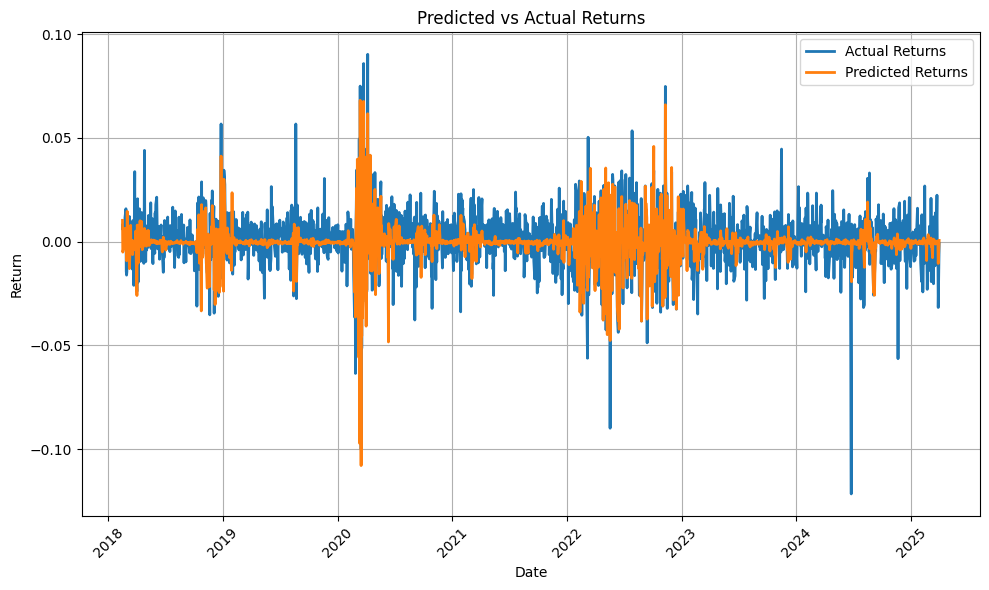

In [281]:
import matplotlib.pyplot as plt

dates = test_returns.index[LOOKBACK:].values

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(dates, actuals, label='Actual Returns', linewidth=2)
plt.plot(dates, predictions, label='Predicted Returns', linewidth=2)
plt.title('Predicted vs Actual Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.xticks(rotation=45)  # Rotate the date labels for better visibility
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can notice that our modeldid manage to catch the big spikes in 2020, but it otherwise gives outputs that are really close to the mean

### Models

def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)

        # Added intermediate dense layer with 3 nodes
        self.hidden = nn.Linear(hidden_layer_size, 3)
        self.relu = nn.ReLU()

        self.fc = nn.Linear(3, output_size)

lookback_period=20  RMSE Val: 0.0174  
lookback_period=30  RMSE Val: 0.0160  
lookback_period=50  RMSE Val: 0.0172

---

import torch
import torch.nn as nn

class LSTMModel(nn.Module):

    LOOKBACK = 30

    def __init__(self, input_size=1, hidden_layer_size=100, intermediate_size=20, output_size=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)

        # First dense layer after LSTM
        self.fc1 = nn.Linear(hidden_layer_size, intermediate_size)
        self.relu = nn.LeakyReLU()

        # Second dense layer for final output
        self.fc2 = nn.Linear(intermediate_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out)
        last_time_step = lstm_out[:, -1, :]

        hidden_out = self.relu(self.fc1(last_time_step))
        output = self.fc2(hidden_out)

        return output


RMSE Val: 0.0148

---

In [274]:
torch.save(model.state_dict(), 'model/lstm_model.pth')